In [3]:
import yfinance as yf
import numpy as np, pandas as pd
import datetime
import matplotlib.pyplot as plt
import sys, os
import pickle as pkl


In [4]:
# look at available info on microsoft

msft = yf.Ticker('msft')
info = msft.info

for key, val in info.items():
    print(f'{key} : {val}')

zip : 98052-6399
sector : Technology
fullTimeEmployees : 163000
longBusinessSummary : Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions;

In [5]:
'''# collect data for list of ticks and visualize price over 10 years:
   # only do this once and then load results from disk

start, end = '2010-01-01', '2020-01-01'
ticker_list = [t.replace('\n', '') for t in open('tickers.txt', 'r').readlines()]
close_dict = {}

plt.figure(figsize=(10, 5))

for tick in ticker_list:
    
    try:
        stock = yf.Ticker(tick)
        df = stock.history(start=start, end=end)
        print(tick, len(df))
    
        # only consider if plotted
        if len(df)==2516:
            closes = df['Close']
            close_dict[tick] = closes
            plt.plot(closes, label=tick)
        
    except:
        print(f'{tick} not added')

#close_list = np.array(close_list)
print(len(close_dict)) 
    
plt.legend()
plt.xlabel('Year', fontsize=16)
plt.ylabel('Share price', fontsize=16)

# collect data on all ticks and save to memory, can load this later
pkl.dump(close_dict, open('close_dict.pkl', 'wb'))  '''


"# collect data for list of ticks and visualize price over 10 years:\n   # only do this once and then load results from disk\n\nstart, end = '2010-01-01', '2020-01-01'\nticker_list = [t.replace('\n', '') for t in open('tickers.txt', 'r').readlines()]\nclose_dict = {}\n\nplt.figure(figsize=(10, 5))\n\nfor tick in ticker_list:\n    \n    try:\n        stock = yf.Ticker(tick)\n        df = stock.history(start=start, end=end)\n        print(tick, len(df))\n    \n        # only consider if plotted\n        if len(df)==2516:\n            closes = df['Close']\n            close_dict[tick] = closes\n            plt.plot(closes, label=tick)\n        \n    except:\n        print(f'{tick} not added')\n\n#close_list = np.array(close_list)\nprint(len(close_dict)) \n    \nplt.legend()\nplt.xlabel('Year', fontsize=16)\nplt.ylabel('Share price', fontsize=16)\n\n# collect data on all ticks and save to memory, can load this later\npkl.dump(close_dict, open('close_dict.pkl', 'wb'))  "

Text(0, 0.5, 'Share price')

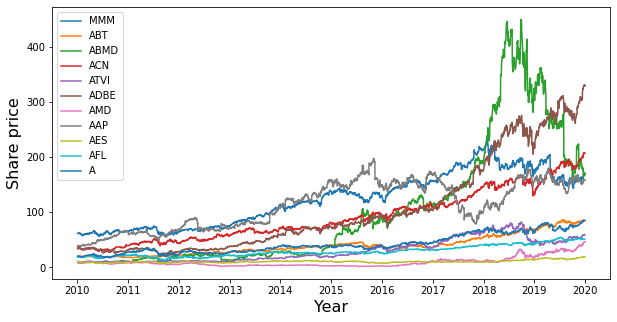

In [71]:
# load close_dict for all ticks from disk
close_dict = pkl.load(open('close_dict.pkl', 'rb'))

# plot the first few ticks:
n_ticks = 10
plt.figure(figsize=(10, 5))

for i, (tick, traj) in enumerate(close_dict.items()):
    plt.plot(traj, label=tick)
    
    if i==n_ticks:
        break
    
plt.legend()
plt.xlabel('Year', fontsize=16)
plt.ylabel('Share price', fontsize=16)

In [85]:
def sma(traj, window):
    '''calculate simple rolling average over select window'''
    
    sma = np.convolve(traj, np.ones(window)/window, mode='valid')
    #sma = []
    #for i in range(0, len(traj)-window):
        #sma.append(np.mean(traj[i:i+window]))
    return np.array(sma)

def check_switch(sma_short, sma_long):
    '''checks when short and long sma crossover over occurs'''
    '''return action list: 0= nothing, [0, 1]=sell, [1, 0]=buy'''
    
    sma_diff = sma_long-sma_short
    actions = []
    
    for i in range(len(sma_diff)-1):
        
        # check if change in sign
        if sma_diff[i]*sma_diff[i+1] < 0:
            
            # sma long is greater: sell!
            if sma_diff[i+1] > sma_diff[i]:
                actions.append([0, 1])
            
            # sma short is greater: buy!
            else: actions.append([1, 0])
        
        # no change: take no action
        else: actions.append([0, 0])
    
    return np.array(actions)

# compute sma for two window sizes, traditional seperated by factor of 2
w_short, w_long = 50, 100
corr_factor = (w_long - w_short)//2
sma_short, sma_long, actions = {}, {}, {}

for tick, traj in close_dict.items():
    sma_short[tick] = sma(traj, w_short)[corr_factor:-corr_factor]
    sma_long[tick] = sma(traj, w_long)
    actions[tick] = check_switch(sma_short[tick], sma_long[tick])
    
print(len(sma(traj, w_short)[corr_factor:-corr_factor]), len(sma(traj, w_long)))


2417 2417


19.868
19.868


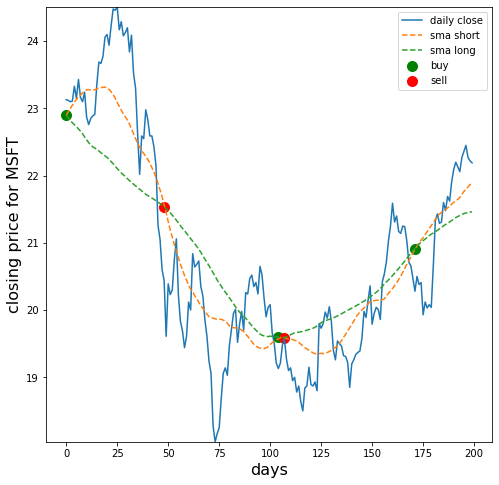

In [90]:
# show proposed buying strategy for an example stock

plt.figure(figsize=(8, 8))
test_tick = 'MSFT'
max_plot = 200
xis = np.arange(max_plot)

print(np.mean(close_dict[test_tick][w_long:w_long+w_short]))
print(np.mean(close_dict[test_tick][w_long:w_long+w_short]))

plt.plot(xis, close_dict[test_tick][w_short:max_plot+w_short], label='daily close')
plt.plot(xis, sma_short[test_tick][:max_plot], label='sma short', linestyle='dashed')
plt.plot(xis, sma_long[test_tick][:max_plot], label='sma long', linestyle='dashed')

# plot buys and sells seperately
plt.scatter(xis, actions[test_tick][:max_plot, 0]*sma_long[test_tick][:max_plot], label='buy', 
            color='g', s=100)
plt.scatter(xis, actions[test_tick][:max_plot, 1]*sma_long[test_tick][:max_plot], label='sell', 
            color='r', s=100)
plt.ylim(np.min(close_dict[test_tick][w_short:max_plot+w_short]), 
         np.max(close_dict[test_tick][w_short:max_plot+w_short]))
plt.xlabel('days', fontsize=16)
plt.ylabel(f'closing price for {test_tick}', fontsize=16)
plt.legend()

In [87]:
# set up a portfolio to test various investing strategiess

class Portfolio:
    '''stores shares of each stock and cash on hand
       stock_dict formatted by 'tick':n_shares
    '''
    
    def __init__(self, cash, init_dict={}):
        '''initialize empty dict by default'''
        
        self.cash = cash
        self.stock_dict = init_dict
        
    def get_price(self, tick, time):
        '''get the instantaneous price for a stock'''
        
        return close_dict[tick][time]
        
    def buy(self, tick, n_shares, time):
        '''purchase n_shares of tick for price'''
        
        price = self.get_price(tick, time)
        self.stock_dict[tick] += n_shares
        self.cash -= n_shares*price
        pass
    
    def sell(self, tick, n_shares, time):
        '''sell n_shares of tick for price'''
        
        price = self.get_price(tick, time)
        self.stock_dict[tick] -= n_shares
        self.cash += n_shares*price
        pass
    
    def liquidate(self, time):
        '''sell all stocks into cash'''
        
        for tick, all_shares in self.stock_dict.items():
            self.sell(tick, all_shares, time)
    
    def get_value(self, time, n_top=5):
        '''sum cash on hand with stock value and return'''
        
        val_list = []
        tick_list = []
        for tick, all_shares in self.stock_dict.items():
            price = self.get_price(tick, time)
            val_list.append(all_shares*price)
            tick_list.append(tick_list)
            
        return self.cash + np.sum(val_list)
     

-6.548361852765083e-10


Text(0, 0.5, 'portfolio value')

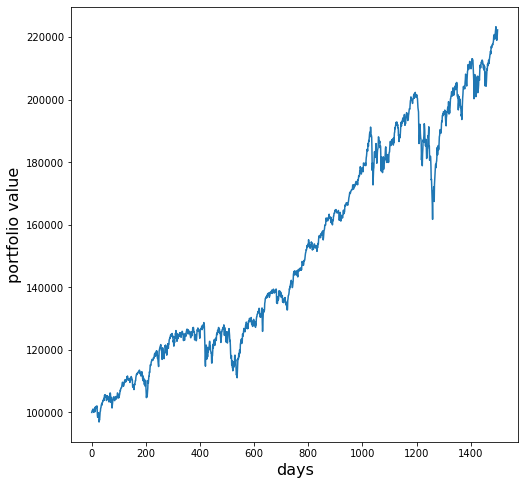

In [83]:
# as a control just buy an equal amount of each stock and don't sell until 2020

# initial and final times -- there should be adquate buffer for the long sma window
ti, tf = 1000, 2500

initial_cash = 100000
n_ticks = len(close_dict)
cash_per_tick = initial_cash / n_ticks

# generate initial shares per stock:
init_dict = {}
spent_cash = 0
for tick, closes in close_dict.items():
    
    # buy all at very first price
    init_price = closes[ti]
    n_shares = cash_per_tick / init_price
    init_dict[tick] = n_shares
    spent_cash += init_price*n_shares

# initialized the portfolio
extra_cash = initial_cash - spent_cash
port_control = Portfolio(extra_cash, init_dict)
print(port_control.cash) #, '\n', port_control.stock_dict)

# report totally portfolio value over time
val_list = []
for t in range(ti, tf):
    val_list.append(port_control.get_value(t))
    
plt.figure(figsize=(8, 8))
plt.plot(val_list, label='hands-off strategy')
plt.xlabel('days', fontsize=16)
plt.ylabel('portfolio value', fontsize=16)

In [113]:
# tune purchasing strategy based on sma crossover
# wiki soybean example: https://en.wikipedia.org/wiki/Trend_following

def invert_actions(actions):
    '''convert from dict of trajs to traj of dicts'''

    traj_list = [val for val in actions.values()]
    n_steps = len(traj_list[0])
    
    buy_trajs = [[] for n in range(n_steps)]
    sell_trajs = [[] for n in range(n_steps)]
    
    print(len(buy_trajs))
    
    for tick, traj in actions.items():
        
        print(tick)
        for t, act in enumerate(traj):
            
            # add to buy_trajs
            if act[0] == 1:
                buy_trajs[t].append(tick)
                
            # add to sell_trajs
            if act[1] == 1:
                sell_trajs[t].append(tick)
                
    return (buy_trajs, sell_trajs)
    
buy_trajs, sell_trajs = invert_actions(actions)
print(buy_trajs)

2416
MMM
ABT
ABMD
ACN
ATVI
ADBE
AMD
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
ANTM
AON
AOS
APA
AIV
AAPL
AMAT
ADM
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
BKR
BLL
BAC
BK
BAX
BDX
BBY
BIIB
BLK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
CHRW
COG
CDNS
CPB
COF
CAH
KMX
CCL
CAT
CBRE
CE
CNC
CNP
CERN
CF
SCHW
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CTXS
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
CXO
COP
ED
STZ
COO
CPRT
GLW
COST
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
DLR
DFS
DISCA
DISCK
DISH
DG
DLTR
D
DPZ
DOV
DTE
DUK
DRE
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
EMR
ETR
EOG
EFX
EQIX
EQR
ESS
EL
EVRG
ES
RE
EXC
EXPE
EXPD
EXR
XOM
FFIV
FAST
FRT
FDX
FIS
FITB
FE
FISV
FLIR
FLS
FMC
F
FTNT
BEN
FCX
GPS
GRMN
IT
GD
GE
GIS
GPC
GILD
GL
GPN
GS
GWW
HRB
HAL
HBI
HOG
HIG
HAS
PEAK
HSIC
HSY
HES
HFC
HOLX
HD
HON
HRL
HST
HWM
HPQ
HUM
HBAN
IEX
IDXX
ITW
ILMN
INCY
INTC
ICE
IBM
IP
IPG
IFF
INTU
ISRG
IVZ
IPGP
IRM
JKHY
J
JBHT
SJM
JNJ
JCI
JPM
JNPR
KSU
K
KEY
KMB


In [115]:
# start a new portfolio with same conditions
trend_port = Portfolio(extra_cash, init_dict)
for t in range(ti, ti+5): #tf
    
    # shift to fit sma and actions
    t_sma = t+w_short
    
    # get lists of buys and sells at given timestep
    buy_list = buy_trajs[t_sma]
    sell_list = sell_trajs[t_sma]
    
    print(t, buy_list, sell_list)
    

1000 ['ACN', 'APA', 'AZO', 'BLL', 'CNC', 'DHI', 'DG', 'EA', 'KMB', 'MRK', 'PNR', 'ROP', 'SRE', 'UNP', 'WFC'] []
1001 ['A', 'AVGO', 'HOLX', 'IEX', 'IDXX', 'IPG', 'KR', 'LIN', 'MHK', 'MNST', 'NI', 'OXY', 'RHI', 'ROK', 'SNA', 'TT', 'YUM'] ['HPQ']
1002 ['ALXN', 'AAL', 'XRAY', 'DD', 'EOG', 'FLS', 'IT', 'HES', 'ICE', 'IFF', 'SJM', 'MCHP', 'MU', 'PNC', 'SPGI', 'SWKS', 'TROW', 'UHS'] ['TPR']
1003 ['ADI', 'CDNS', 'CI', 'EVRG', 'BEN', 'GPS', 'LEN', 'LYV', 'TAP', 'JWN', 'SBAC', 'SYK'] []
1004 ['ARE', 'CTAS', 'EQIX', 'ESS', 'HUM', 'INCY', 'JKHY', 'JCI', 'PNW', 'PHM', 'TIF', 'UDR', 'WY', 'XEL'] ['FLS', 'ICE']
